In [3]:
"""An example notebook for a data_analysis notebook you may write.

Please use the recommended TNR font unless your venue requires otherwise.
"""

# Write down all of your code for data analysis in this file.
# Plot the data and save the figures/tables in the folders "plots" and "tables"
import matplotlib.pyplot as plt
import seaborn as sns

# Use TNR for all figures
# to match paper templates
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = [
    "Times New Roman",
] + plt.rcParams["font.serif"]

# Whitegrid is most appropriate
# for scientific papers
sns.set_style("whitegrid")

# An optional colorblind palette
# for figures
CB_color_cycle = [
    "#377EB8",
    "#FF7F00",
    "#4DAF4A",
    "#F781BF",
    "#A65628",
    "#984EA3",
    "#999999",
    "#E41A1C",
    "#DEDE00",
]

In [4]:
from pathlib import Path
import json
import pandas as pd
import numpy as np

/tmp/ipykernel_283551/2625252216.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  histplot = sns.histplot(


mode=165.5929648241206


/tmp/ipykernel_283551/2625252216.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  histplot = sns.histplot(
/tmp/ipykernel_283551/2625252216.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  histplot = sns.histplot(


mode=140.31658291457285
mode=140.58793969849245


/tmp/ipykernel_283551/2625252216.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  histplot = sns.histplot(


mode=143.17085427135677


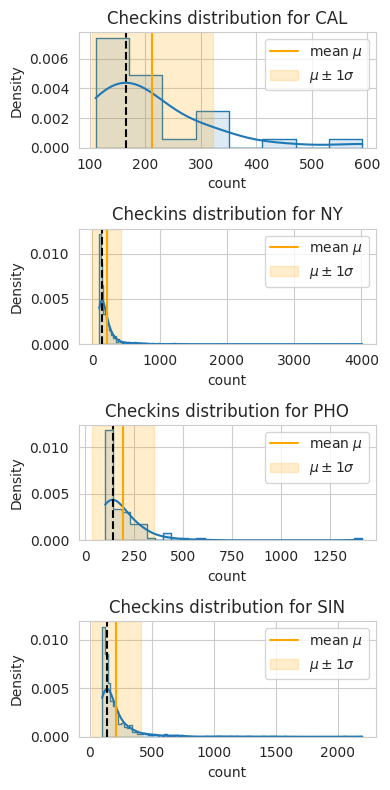

In [41]:
fig, axes = plt.subplots(4, 1, squeeze=False, figsize=(4, 8))
for i, city in enumerate(("CAL", "NY", "PHO", "SIN")):
    postprocessed_path = Path.cwd().parent / "data" / "flashback" / "partition" / city / "centralised" / "client_0.txt"
    df_postprocessed = pd.read_csv(postprocessed_path, sep="\t", header=None)
    checkin_distribution_postprocessed = df_postprocessed.loc[:, 0].value_counts()
    binwidth = (checkin_distribution_postprocessed.max() - checkin_distribution_postprocessed.min()) // 20

    histplot = sns.histplot(
        alpha=0.15,
        legend=True,
        data=checkin_distribution_postprocessed,
        fill=True,
        kde=True,
        element="step",
        stat="density",
        common_norm=False,  # there is only 1 histogram here, so this is inconsequential
        common_bins=True,
        cbar=True,  # this is a univariate plot (1 dependent variable: # samples), so this is inconsequential
        palette="dark",
        ax=axes[i, 0]
    )  # corresponds to histplot.get_lines()[0]
    mu = np.mean(checkin_distribution_postprocessed)
    sigma = np.std(checkin_distribution_postprocessed)  # standard deviation
    axes[i, 0].axvline(mu, color="orange", label="mean $\mu$")  # corresponds to histplot.get_lines()[1]
    axes[i, 0].axvspan(mu - sigma, mu + sigma, label="$\mu \pm 1 \sigma$", color="orange", alpha=0.2)
    axes[i, 0].legend()

    # Mode finding from KDE courtesy of https://stackoverflow.com/a/72222126
    x, y = histplot.get_lines()[0].get_data()
    mode = x[np.argmax(y)]
    print(f"mode={mode}")
    axes[i, 0].axvline(mode, ls="--", color="black")  # For demo purposes only

    axes[i, 0].set_title(f"Checkins distribution for {city}")

    # plt.xlabel("# samples")

    # fig, axes = plt.subplots(1, 2, figsize=(9, 2), squeeze=False)
    # sns.histplot(checkin_distribution_raw, stat="count", binwidth=binwidth, ax=axes[0, 0])
    # sns.histplot(checkin_distribution_postprocessed, stat="count", binwidth=binwidth, ax=axes[0, 1])
    # axes[0, 0].set_title("Raw dataset")
    # axes[0, 0].set_yscale("log")
    # axes[0, 1].set_title("Flashback-Postprocessed dataset\nmust have at least $101$ checkins")
    # axes[0, 1].set_yscale("log")
    # fig.suptitle(f"Checkins distribution for {city}", y=1.2)
    # plt.show()
    # break

plt.tight_layout()
plt.show()

In [115]:
from numpy.typing import ArrayLike
def find_mode(distribution: ArrayLike) -> float:
    histplot = sns.histplot(data=distribution, kde=True, element="step")  # corresponds to histplot.get_lines()[0]
    plt.close()  # prevent showing of plot

    # Mode finding from KDE courtesy of https://stackoverflow.com/a/72222126
    x, y = histplot.get_lines()[0].get_data()
    mode = x[np.argmax(y)]
    return mode

find_mode([1,2,3,4,5,6,7,7,7,7,8])

6.663316582914573

In [127]:
sequence_length=20

In [144]:
city = "CAL"
df = pd.read_csv(Path.cwd().parent / "data" / "flashback" / "raw_data" / city / "CAL_checkin.csv")
df = df.loc[:, ["UserId", "Local_Time", "Latitude", "Longitude", "VenueId"]]

# Deal with time
df.loc[:, "Local_Time"] = pd.to_datetime(
    df.loc[:, "Local_Time"],
    dayfirst=city == "CAL",  # peculiarity of the MCMG dataset
    yearfirst=city != "CAL",  # peculiarity of the MCMG dataset
    utc=True,
)
df.loc[:, "Local_Time"] = df.loc[:, "Local_Time"].apply(
    lambda t: t.strftime("%Y-%m-%dT%H:%M:%SZ")
)
df = df.sort_values(
    by=["UserId", "Local_Time"]
)  # Flashback expects checkins from the same user to be bunched together

debug_total_checkins_before_drop = len(df)
debug_total_users_before_drop = len(df.loc[:, "UserId"].unique())

# Drop users with insufficient checkins
required_minimum_checkins = 5 * sequence_length + 1
print(f"With sequence_length={sequence_length}, we have required_minimum_checkins={required_minimum_checkins}")
num_checkins_per_user = df.loc[:, "UserId"].value_counts()
df.loc[:, "num_checkins_from_this_user"] = df.loc[:, "UserId"].apply(
    lambda i: num_checkins_per_user[i]
)
df = df.loc[
    df.loc[:, "num_checkins_from_this_user"] >= required_minimum_checkins,
    :  #* this column is useful for within-barricade operations below, retain it for now
]

# * Extra processing compared to _preprocess_data_all_clients() happens within
# * these barricades
# * //////////////////////////////////////////////////////////////////////// * #

# Checkins distribution
num_checkins_per_user = df.loc[:, "UserId"].value_counts()
mu = np.mean(num_checkins_per_user)
sigma = np.std(num_checkins_per_user)  # standard deviation

# Keep only clients with number of checkins inside [mu - sigma, mu + sigma] (both inclusive; liberally allow more otherwise small datasets will have problem...)
accept = (df.loc[:, "num_checkins_from_this_user"] >= mu - sigma) & (df.loc[:, "num_checkins_from_this_user"] <= mu + sigma)
df = df.loc[
    accept,
    df.columns != "num_checkins_from_this_user",
]
print(mu)
print(mu-sigma, mu+sigma)
df.loc[:, "UserId"].value_counts()


# venue_ids = list(df.loc[:, "VenueId"].unique())
# df.loc[:, "VenueId"] = df.loc[:, "VenueId"].map(venue_ids.index)
# # Mapping arbitrary integer `UserId`s to integer client IDs starting from 0, as expected by Flower
# user_ids = list(df.loc[:, "UserId"].unique())
# df.loc[:, "UserId"] = df.loc[:, "UserId"].map(user_ids.index)

# debug_total_checkins_after_drop = len(df)
# debug_total_users_after_drop = len(df.loc[:, "UserId"].unique())

len(df)

With sequence_length=20, we have required_minimum_checkins=101
212.66666666666666
104.09342802956904 321.23990530376426


4713

mode=165.5929648241206
mode=140.31658291457285
mode=140.58793969849245
mode=143.17085427135677


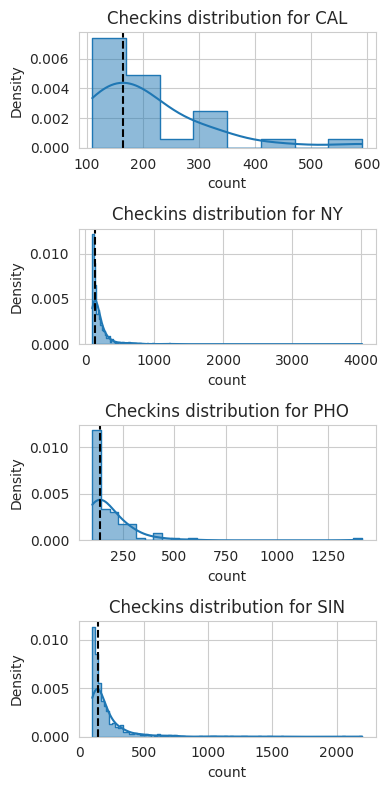

In [40]:
fig, axes = plt.subplots(4, 1, squeeze=False, figsize=(4, 8))
for i, city in enumerate(("CAL", "NY", "PHO", "SIN")):
    postprocessed_path = Path.cwd().parent / "data" / "flashback" / "partition" / city / "centralised" / "client_0.txt"
    df_postprocessed = pd.read_csv(postprocessed_path, sep="\t", header=None)
    checkin_distribution_postprocessed = df_postprocessed.loc[:, 0].value_counts()
    binwidth = (checkin_distribution_postprocessed.max() - checkin_distribution_postprocessed.min()) // 20

    histplot = sns.histplot(
        data=checkin_distribution_postprocessed,
        kde=True,
        element="step",
        stat="density",
        ax=axes[i, 0]
    )  # corresponds to histplot.get_lines()[0]
    mu = np.mean(checkin_distribution_postprocessed)
    sigma = np.std(checkin_distribution_postprocessed)  # standard deviation

    # Mode finding from KDE courtesy of https://stackoverflow.com/a/72222126
    x, y = histplot.get_lines()[0].get_data()
    mode = x[np.argmax(y)]
    print(f"mode={mode}")
    axes[i, 0].axvline(mode, ls="--", color="black")  # For demo purposes only

    axes[i, 0].set_title(f"Checkins distribution for {city}")

plt.tight_layout()
plt.show()

In [84]:
import math

In [90]:
df = pd.read_csv(Path.cwd().parent / "data" / "flashback" / "raw_data" / "CAL" / "CAL_checkin.csv")
df = df.loc[:, ["UserId"]]
distribution = df.loc[:, "UserId"].value_counts()
mode = find_mode(distribution)
# df.loc[:, "difference_from_mode"] = (df.loc[:, ["UserId"]] - mode).abs()
# df = df.sort_values(by="difference_from_mode", ascending=True)
# df # distribution - mode
assert len(distribution) == len(df.loc[:, "UserId"].unique())
users = len(df.loc[:, "UserId"].unique())
print(users)

(distribution - mode).abs().sort_values(kind="stable")[:math.ceil(0.15 * users)]

130


UserId
204593     0.442211
216211     1.442211
67279      1.442211
238217     1.557789
255357     2.557789
234005     3.557789
196461     4.557789
201143     7.557789
264040     8.557789
252848    10.442211
229317    10.442211
132941    10.442211
80439     10.557789
193643    10.557789
125958    12.557789
140752    13.557789
238329    14.442211
122380    14.557789
111727    15.442211
256556    15.442211
Name: count, dtype: float64

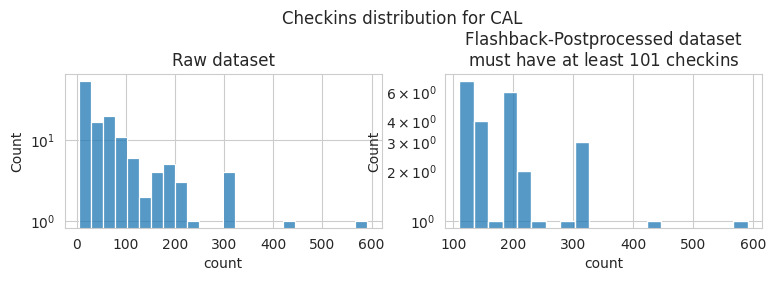

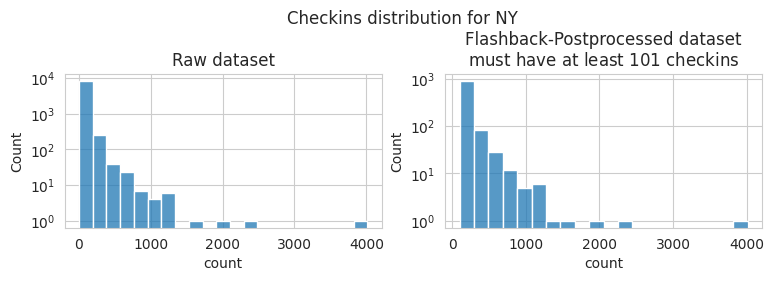

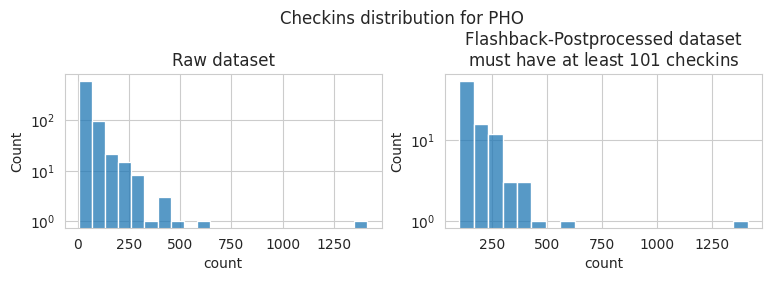

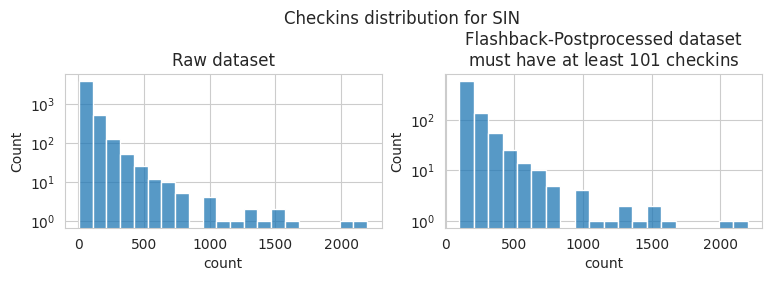

In [56]:
for city in ("CAL", "NY", "PHO", "SIN"):
    raw_path = Path.cwd().parent / "data" / "flashback" / "raw_data" / city / f"{city}_checkin.csv"
    df_raw = pd.read_csv(raw_path)
    checkin_distribution_raw = df_raw.loc[:, "UserId"].value_counts()

    postprocessed_path = Path.cwd().parent / "data" / "flashback" / "partition" / city / "centralised" / "client_0.txt"
    df_postprocessed = pd.read_csv(postprocessed_path, sep="\t", header=None)
    checkin_distribution_postprocessed = df_postprocessed.loc[:, 0].value_counts()
    binwidth = (checkin_distribution_postprocessed.max() - checkin_distribution_postprocessed.min()) // 20

    fig, axes = plt.subplots(1, 2, figsize=(9, 2), squeeze=False)
    sns.histplot(checkin_distribution_raw, stat="count", binwidth=binwidth, ax=axes[0, 0])
    sns.histplot(checkin_distribution_postprocessed, stat="count", binwidth=binwidth, ax=axes[0, 1])
    axes[0, 0].set_title("Raw dataset")
    axes[0, 0].set_yscale("log")
    axes[0, 1].set_title("Flashback-Postprocessed dataset\nmust have at least $101$ checkins")
    axes[0, 1].set_yscale("log")
    fig.suptitle(f"Checkins distribution for {city}", y=1.2)
    plt.show()

In [63]:
experiment_to_result_paths = {
    "centralised-cal": Path.cwd().parent / "multirun" / "2024-03-22" / "03-34-41" / "0",
    "centralised-ny": Path.cwd().parent / "multirun" / "2024-03-22" / "03-34-41" / "1",
    "centralised-pho": Path.cwd().parent / "multirun" / "2024-03-22" / "03-34-41" / "2",
    "centralised-sin": Path.cwd().parent / "multirun" / "2024-03-22" / "03-34-41" / "3",
    "federated-cal": Path.cwd().parent / "multirun" / "2024-03-22" / "03-34-41" / "4",
    "federated-ny": Path.cwd().parent / "multirun" / "2024-03-22" / "14-33-11" / "0",
    "federated-pho": Path.cwd().parent / "multirun" / "2024-03-22" / "14-33-11" / "1",
    "federated-sin": Path.cwd().parent / "multirun" / "2024-03-22" / "14-33-11" / "2"
}

for experiment_name, dir_path in experiment_to_result_paths.items():
    history_path = dir_path / "results" / "state" / "histories" / "history.json"
    with history_path.open("r") as f:
        df = json.load(f)
    losses_distributed = df["losses_distributed"]  # losses from each client at final epoch of each round, weighted averaged
    metrics_distributed_fit = df["metrics_distributed_fit"]  # train metrics from each client at final epoch of each round, weighted averaged
    metrics_distributed = df["metrics_distributed"]  # test metrics from each client at final epoch of each round, weighted averaged
    losses_centralised = df["losses_centralized"]  # loss at each round using centralised dataset at server
    metrics_centralised = df["metrics_centralized"]  # test metrics at each round using centralised dataset at server

    break

print(losses_distributed)
print(metrics_distributed_fit)
print(metrics_distributed)
print(losses_centralised)
print(metrics_centralised)

[[1, 3.865387487411499]]
{'train_loss': [[1, 2.9512485732202944]]}
{'recall@1': [[1, 0.19479166666666667]], 'recall@5': [[1, 0.5041666666666667]], 'recall@10': [[1, 0.6458333333333334]], 'MAP': [[1, 0.33732912627896255]]}
[[0, 6.282036781311035], [1, 3.865387487411499]]
{'recall@1': [[0, 0.0020833333333333333], [1, 0.19479166666666667]], 'recall@5': [[0, 0.010416666666666666], [1, 0.5041666666666667]], 'recall@10': [[0, 0.017708333333333333], [1, 0.6458333333333334]], 'MAP': [[0, 0.014053265590994962], [1, 0.33732912627896255]], 'predictions': [[0, 960.0], [1, 960.0]]}
